# Import Libraries, Load Dataset

In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [65]:
annotations = pd.read_csv("dataset/phase_2_TRAIN_8d8d624e3190984c_05dcbf4_MLPC2021_raw_annotations_generic.csv")
features = pd.read_csv("dataset/phase_2_TRAIN_ab71fa4d86c94323_05dcbf4_MLPC2021_features_generic.csv")

piece_ids = annotations.piece.unique()
students = annotations.student.unique()

In [66]:
# evtl hilfreich wenn wir distanz zum Ursprung brauchen:

annotations_normalized = annotations.copy()
annotations_normalized.arousal = annotations_normalized.arousal / 50. - 1
annotations_normalized.valence = annotations_normalized.valence / 5.

# Exploring Annotations

## Computing simple statistics for each piece

mean, median, variance / sd

In [67]:
plot_data = pd.DataFrame(columns=["piece", "a_sd", "v_sd", "a_variance", "v_variance", "a_mean", "v_mean", "a_median", "v_median"])

for piece in piece_ids:
    piece_annotations = annotations[annotations.piece == piece]
    a = piece_annotations.arousal
    v = piece_annotations.valence
    a_variance = a.var()
    a_sd = np.sqrt(a_variance)
    a_mean = a.mean()
    a_median = a.median()
    v_variance = v.var()
    v_sd = np.sqrt(v_variance)
    v_mean = v.mean()
    v_median = v.median()
    
    plot_data = plot_data.append({"piece":piece,"a_variance": a_variance, "v_variance":v_variance,  "a_sd": a_sd, "v_sd": v_sd,  "a_mean":a_mean, "v_mean":v_mean,"a_median": a_median, "v_median":v_median}, ignore_index=True)


plot_data = plot_data.astype({"piece":int})
plot_data = plot_data.set_index("piece")

# check which piece has the greatest variance in annotations (greatest disagreement)
# plot_data.v_variance == plot_data.v_variance.max()
# plot_data.a_variance == plot_data.a_variance.max()

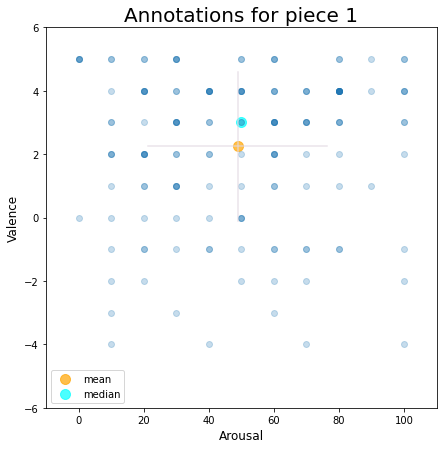

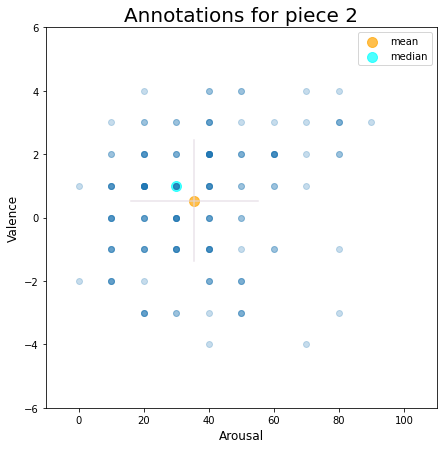

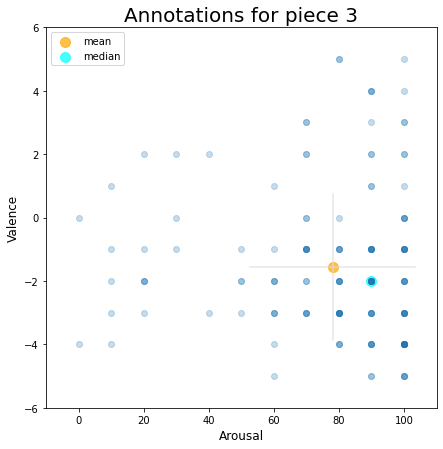

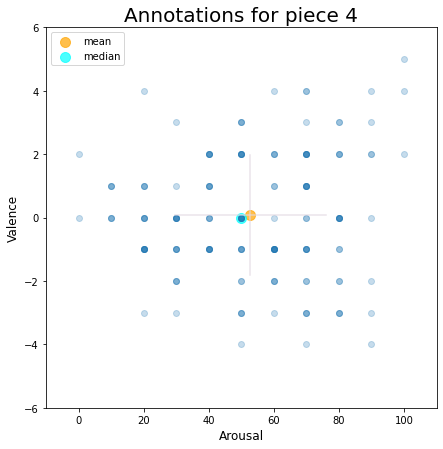

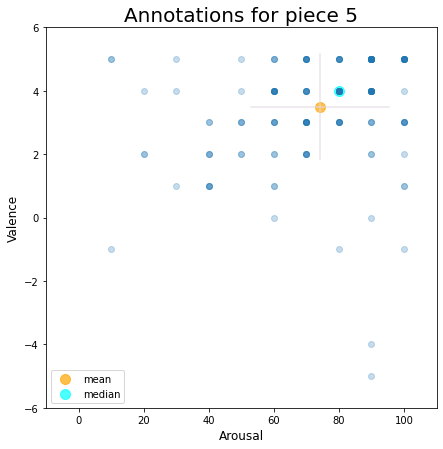

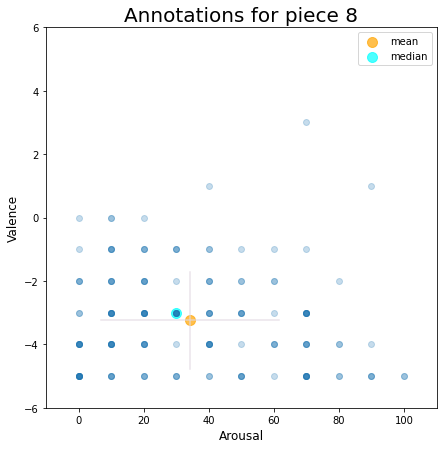

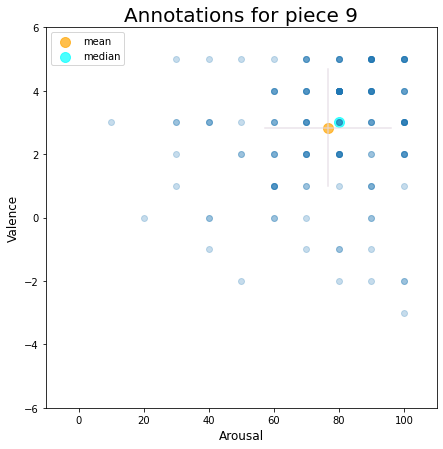

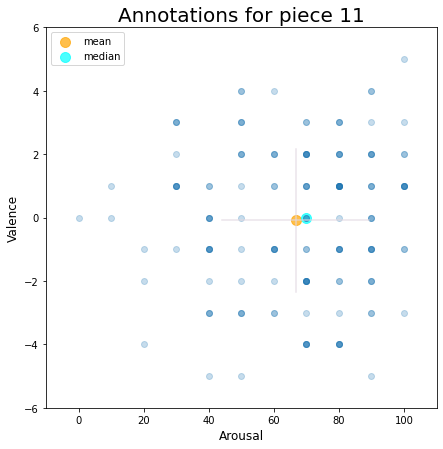

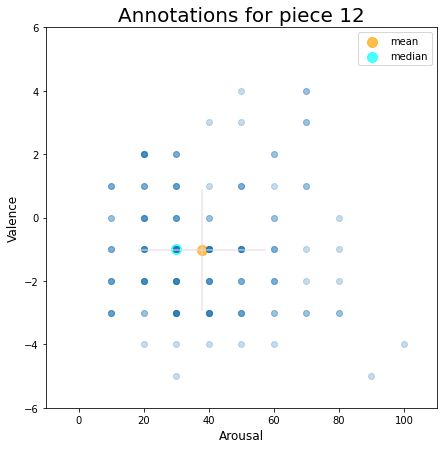

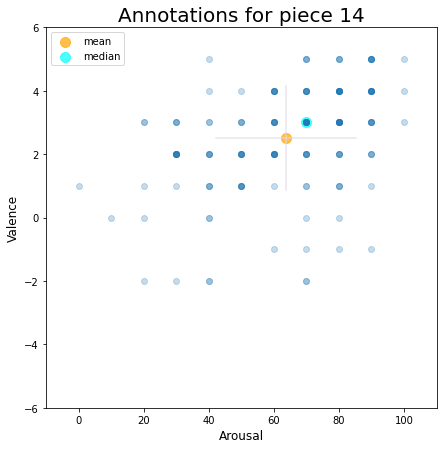

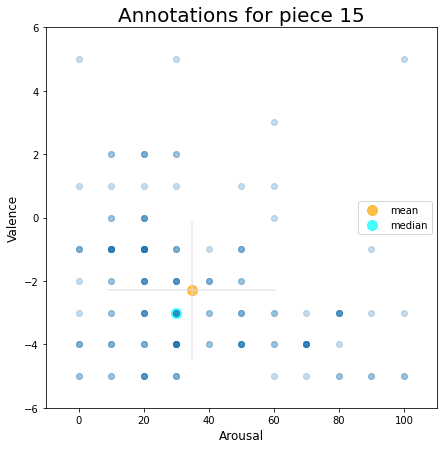

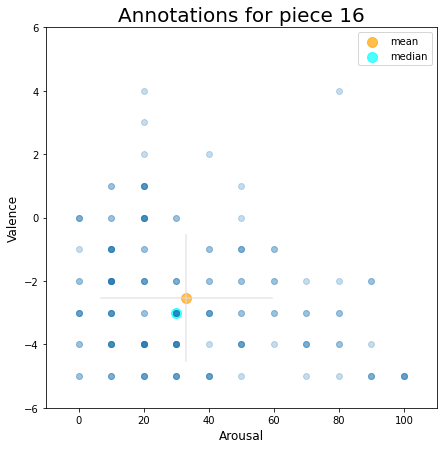

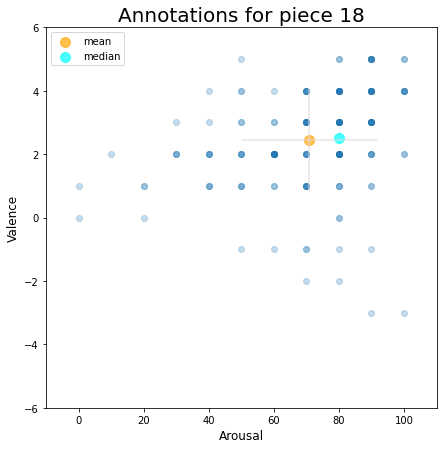

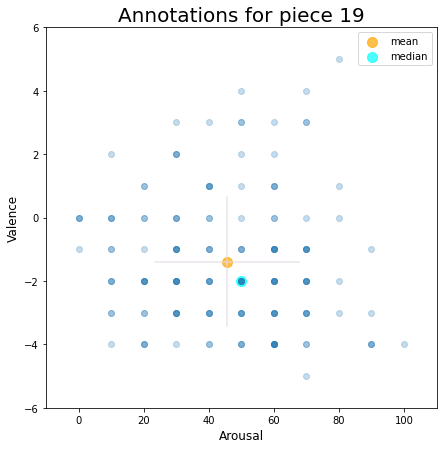

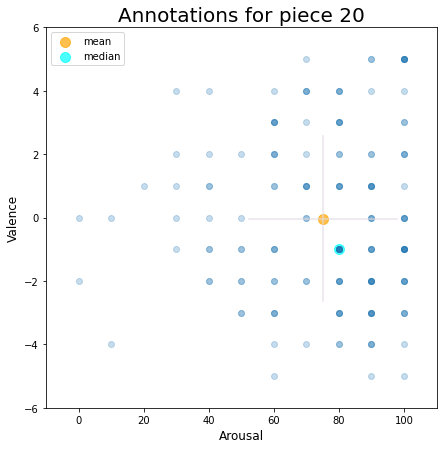

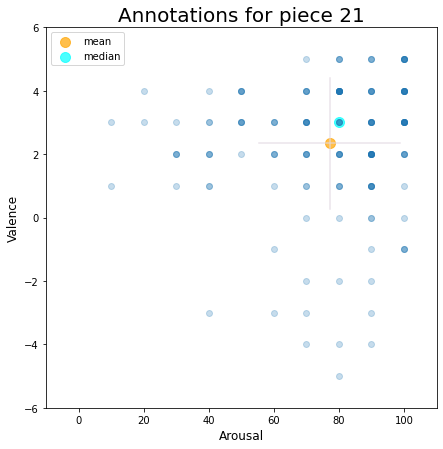

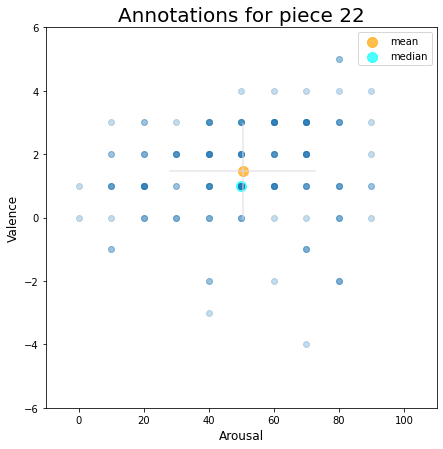

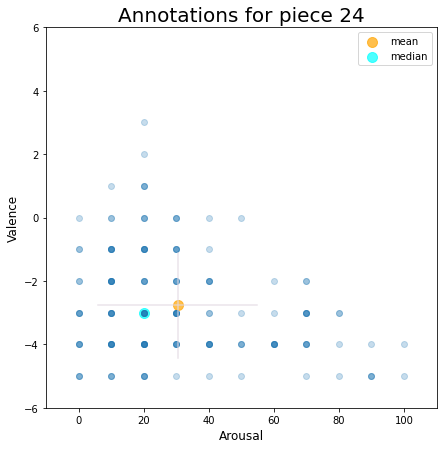

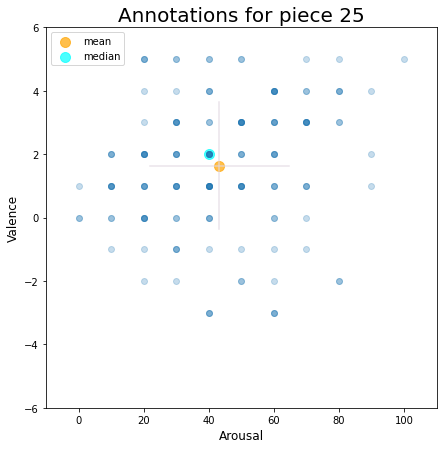

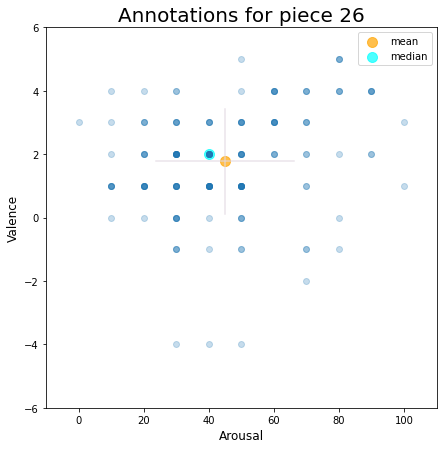

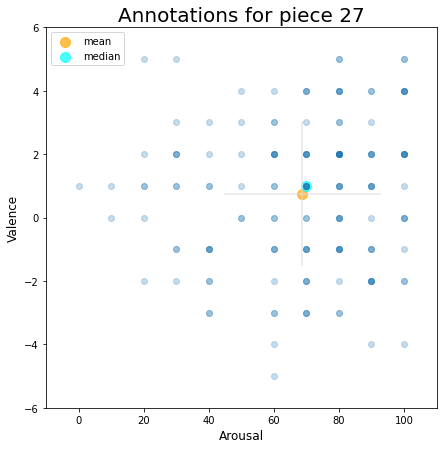

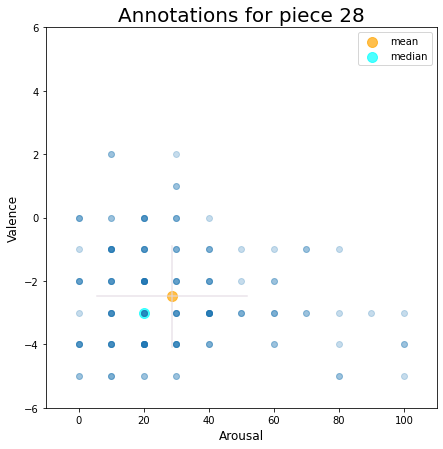

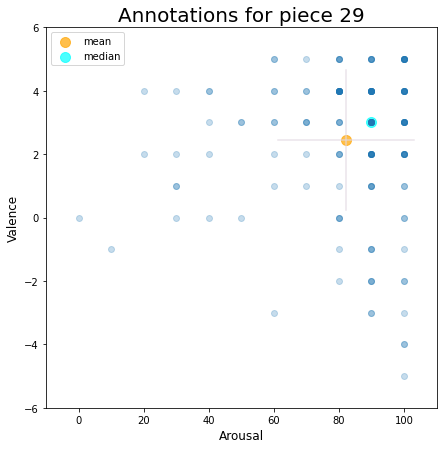

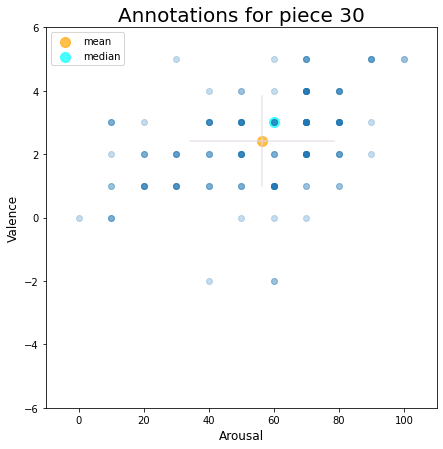

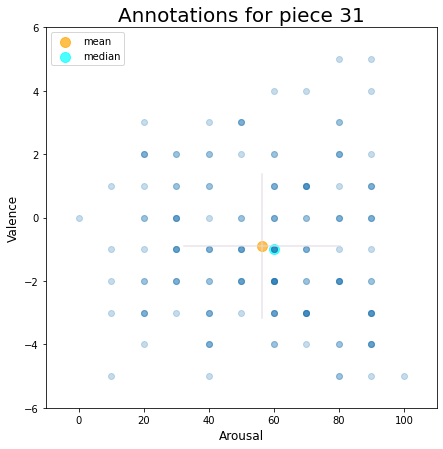

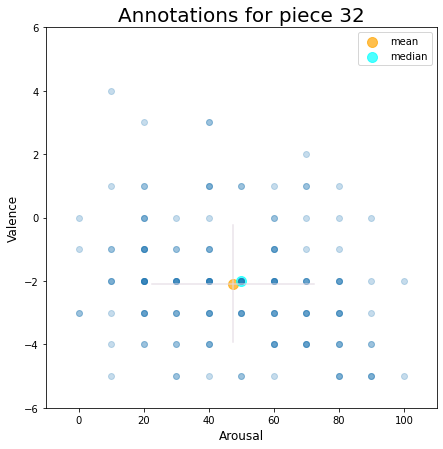

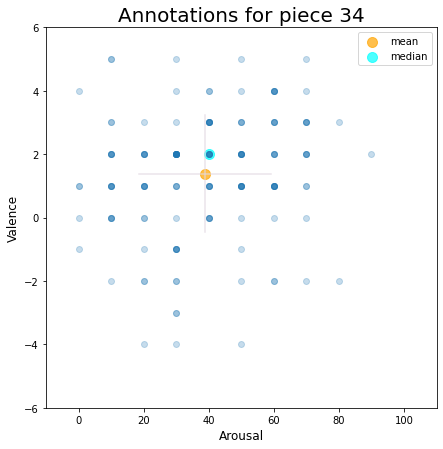

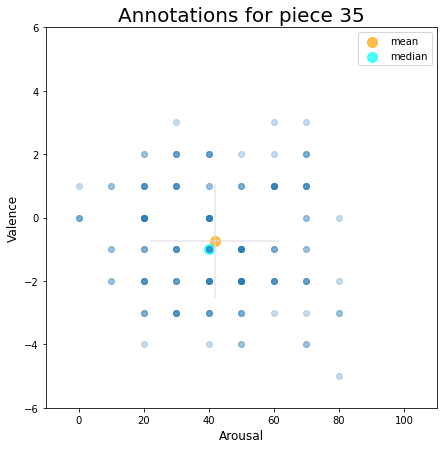

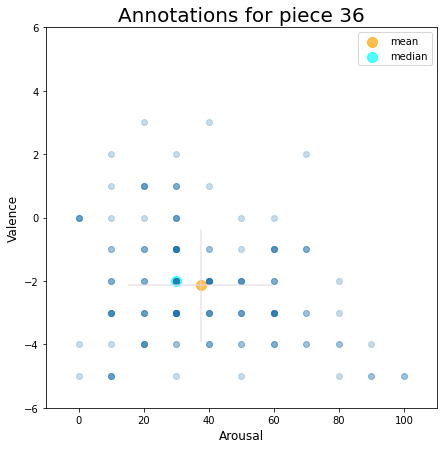

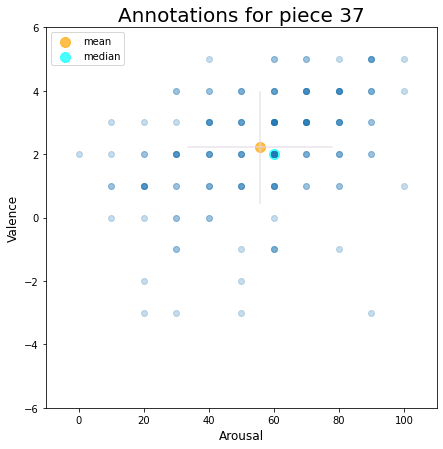

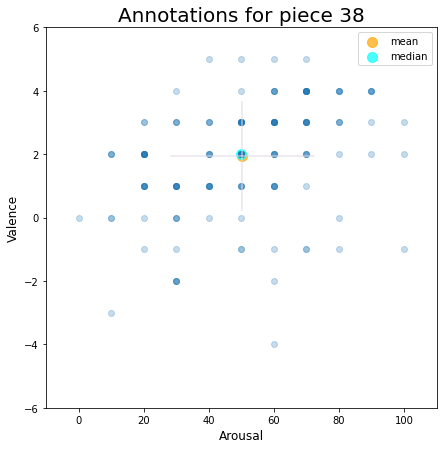

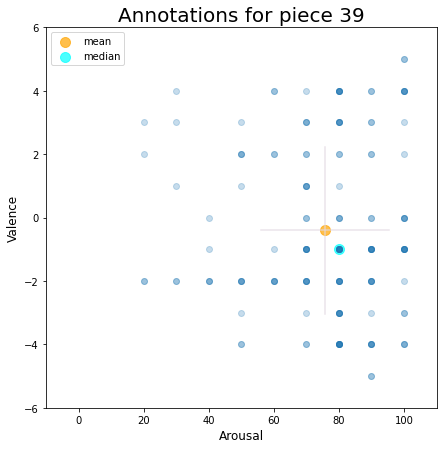

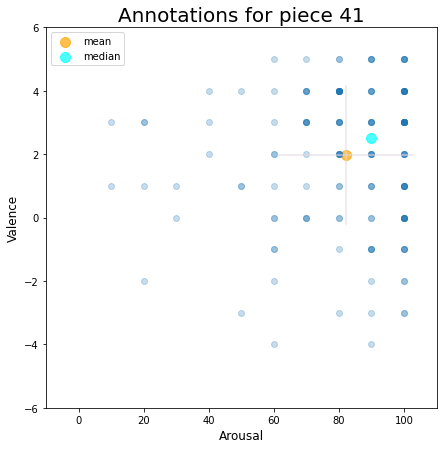

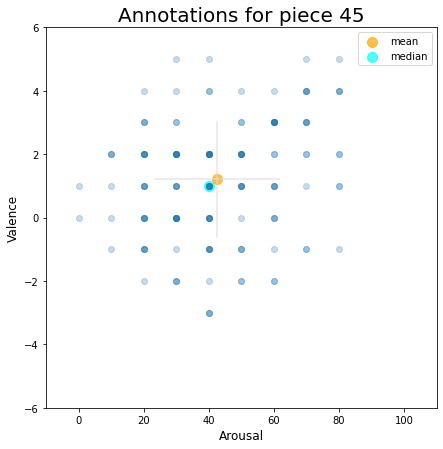

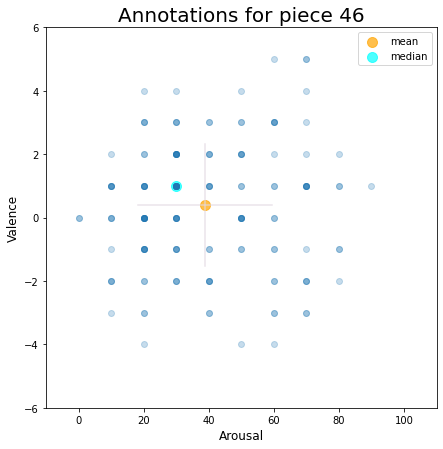

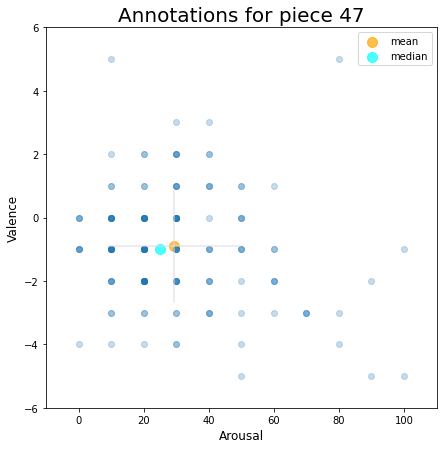

In [68]:

colors = plt.cm.get_cmap('twilight', len(piece_ids))

def plot_annotations(annotations, piece_id):
    filtered_annotations = annotations[annotations.piece == piece_id]
    arousal = filtered_annotations.arousal
    valence = filtered_annotations.valence
    
    a_m = arousal.mean()
    a_median = arousal.median()
    v_m = valence.mean()
    v_median = valence.median()
    
    p = plot_data.loc[piece_id]
    a_sd = p.a_sd
    v_sd = p.v_sd
    
    plt.figure(figsize=(7,7))

    plt.plot([a_m - a_sd, a_m + a_sd], [v_m, v_m], alpha=0.7, color=colors(piece_ids.tolist().index(p_id)))
    plt.plot([a_m, a_m], [v_m-v_sd, v_m+v_sd], alpha=0.7, color=colors(piece_ids.tolist().index(p_id)))
    
    plt.scatter(x=a_m, y=v_m, color="orange", s=100, alpha=0.7, label="mean")
    plt.scatter(x=a_median, y=v_median, color="cyan", s=100, alpha=0.7, label="median")
    plt.scatter(x=arousal, y=valence,  alpha=0.25)
    plt.title("Annotations for piece " + str(piece_id), fontsize=20)
    plt.xlabel("Arousal", fontsize=12)
    plt.legend()
    plt.ylabel("Valence", fontsize=12)
    plt.xlim(-10,110)
    plt.ylim(-6,6)
    plt.show()

n = 31

# randomly choose n elements:
sample_pieces = piece_ids[np.random.choice(len(piece_ids), size=n, replace=False)]

#np.random.sample(piece_ids)
for i in piece_ids:
    plot_annotations(annotations, i)

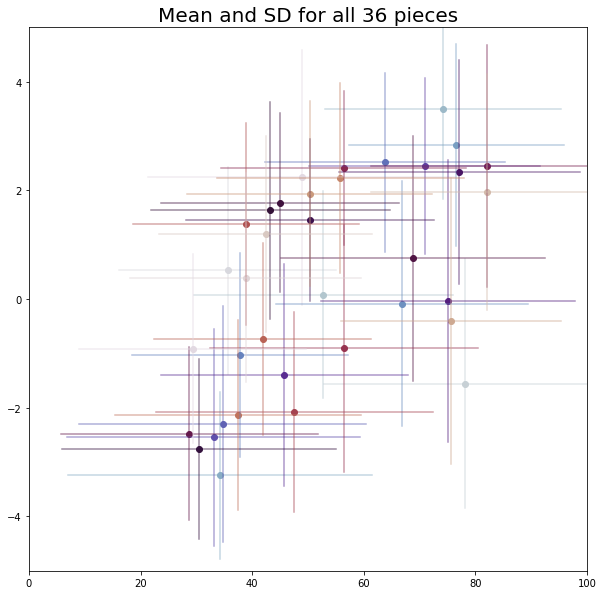

In [69]:

#plt.figure(figsize=(15,8))
plt.figure(figsize=(10,10))

for p_id in piece_ids:
    
    p = plot_data.loc[p_id]
    a_v = p.a_variance
    v_v = p.a_variance
    a_sd = p.a_sd
    v_sd = p.v_sd
    a_m = p.a_mean
    v_m = p.v_mean
    a_med = p.a_median
    v_med = p.v_median

    plt.scatter(x=a_m, y=v_m, color=colors(piece_ids.tolist().index(p_id)))
    plt.plot([a_m - a_sd, a_m + a_sd], [v_m, v_m], alpha=0.5, color=colors(piece_ids.tolist().index(p_id)))
    plt.plot([a_m, a_m], [v_m-v_sd, v_m+v_sd], alpha=0.5, color=colors(piece_ids.tolist().index(p_id)))
    plt.ylim(-5,5)
    plt.xlim(0,100)
    

plt.title("Mean and SD for all 36 pieces", fontsize=20)
plt.show()

# TODO: Exploring Features

In [70]:
features

,id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,...,librosa_spectral_flatness_stdev,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,score_mode,score_key_strength
0,GG-01-000,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,...,0.248388,0.065397,-0.029380,-0.303987,-0.053306,-0.325228,0.347745,-0.119278,0.0,0.795727
1,GG-01-001,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,...,0.000484,0.353040,-0.073957,-0.381182,0.120750,-0.479266,0.451572,-0.064252,0.0,0.844387
2,GG-01-002,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,...,0.000314,0.201885,0.016944,-0.337422,0.103853,-0.388214,0.430684,-0.226197,0.0,0.758119
3,GG-01-003,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,...,0.000257,0.181998,-0.019165,-0.314282,0.118872,-0.335902,0.314371,-0.006619,1.0,0.747180
4,GG-01-004,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,...,0.000241,0.256362,-0.151648,-0.302913,-0.002940,-0.395495,0.368037,-0.162711,0.0,0.710480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,RT-47-029,0.106072,0.048556,4.600393,71.847145,1.7,0.541098,0.146353,3761.501709,1075.834717,...,0.003238,0.357967,-0.189399,-0.294453,-0.048271,-0.518002,0.364257,-0.344354,0.0,0.741726
2603,RT-47-030,0.097130,0.045978,4.032829,81.727577,2.4,0.506956,0.129266,3283.780029,956.233765,...,0.002562,0.223821,-0.081319,-0.211686,-0.043546,-0.427122,0.318351,-0.382207,0.0,0.729813
2604,RT-47-031,0.142735,0.059378,4.094213,27.877666,0.9,0.553664,0.155784,5419.066406,1376.261963,...,0.009679,0.190541,-0.334320,-0.268202,-0.223166,-0.392003,0.249261,-0.183019,0.0,0.752923
2605,RT-47-032,0.134667,0.057092,5.675084,57.549480,1.4,0.524951,0.150398,4481.284668,1550.097534,...,0.007357,0.292983,-0.208947,-0.286899,-0.110805,-0.460086,0.320651,-0.221194,0.0,0.744074
